In [16]:
import sys
import time
import copy

from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference
#from gene_inference.infer_genes import infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
reload(analysis.metrics)
reload(gene_inference);

In [17]:
#tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [18]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = False
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [19]:
graph = Graph()
path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [20]:
# def sample_neighbors(g, gene, num_neighbors, include_self=True):
#     results = set([])
#     if include_self:
#         results = set([gene])
#     all_nodes = set(g.nodes)
#     first_degree = set(g.neighbors(gene))
#     second_degree = set()
#     for x in g.neighbors(gene):
#         second_degree = second_degree.union(set(g.neighbors(x)))
#     while len(results) < num_neighbors:
#         if len(first_degree) - len(results) > 0:
#             unique = sorted(first_degree - results)
#             results.add(unique.pop())
#         elif len(second_degree) - len(results) > 0:
#             unique = sorted(second_degree - results)
#             results.add(unique.pop())
#         else:
#             unique = sorted(all_nodes - results)
#             results.add(unique.pop())
#     return results

In [21]:
def sample_neighbors(g, gene, num_neighbors, include_self=True):
    results = set([])
    if include_self:
        results = set([gene])
    all_nodes = set(g.nodes)
    first_degree = set(g.neighbors(gene))
    second_degree = set()
    for x in g.neighbors(gene):
        second_degree = second_degree.union(set(g.neighbors(x)))
    while len(results) < num_neighbors:
        if len(first_degree) - len(results) > 0:
            unique = first_degree - results
            results.add(np.random.choice(list(unique)))
        elif len(second_degree) - len(results) > 0:
            unique = second_degree - results
            results.add(np.random.choice(list(unique)))
        else:
            unique = all_nodes - results
            results.add(np.random.choice(list(unique)))
    return results

In [22]:
#sample_neighbors(g, "RPL5", 5, include_self=False)

In [165]:
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np

class Method:
    def __init__(self):
        pass

class SkLearn(Method):
    
    def __init__(self, model, penalty=False):
        self.model = model
        self.penalty = penalty
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

        if self.model == "LR":
            model = sklearn.linear_model.LogisticRegression()
            if self.penalty:
                model = sklearn.linear_model.LogisticRegression(penalty='l1', tol=0.0001)
        elif self.model == "DT":
            model = sklearn.tree.DecisionTreeClassifier()
        elif self.model == "MLP":
            model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,3), learning_rate_init=0.001, early_stopping=False,  max_iter=1000)
        else:
            print "incorrect label"
        
        model = model.fit(X_train, y_train)
        return sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


class PyTorch(Method):    
    
    def __init__(self, model, num_epochs=100, num_channel=64, num_layer=3, add_emb=32, use_gate=False, dropout=True, cuda=True):
        self.model = model
        self.batch_size = 10
        self.num_channel = num_channel
        self.num_layer = num_layer
        self.add_emb = add_emb
        self.use_gate = use_gate
        self.dropout = dropout
        self.cuda = cuda
        self.num_epochs = num_epochs
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
    
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
        #split train into valid and train
        local_X_train, local_X_valid, local_y_train, local_y_valid = sklearn.model_selection.train_test_split(X_train, y_train, stratify=y_train, train_size=0.60, random_state=seed)
        local_X_train = torch.FloatTensor(np.expand_dims(local_X_train, axis=2))
        local_X_valid = torch.FloatTensor(np.expand_dims(local_X_valid, axis=2))
        X_test = torch.FloatTensor(np.expand_dims(X_test, axis=2))
        
        local_y_train = torch.FloatTensor(local_y_train)

        criterion = optimization.get_criterion(dataset)
        patience = 20
        opt.num_layer = self.num_layer
        adj_transform, aggregate_function = models.graphLayer.get_transform(opt, adj)
        
        if self.model == "CGN":
            model = models.models.CGN(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1,
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj,
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform,
                    aggregate_adj=aggregate_function,
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    )
        elif self.model == "MLP":
            model = models.models.MLP(
                    len(dataset.df.columns), 
                    channels=[self.num_channel] * self.num_layer, 
                    out_dim=2, 
                    on_cuda=self.cuda, 
                    dropout=self.dropout)
            
        if self.cuda:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            model.cuda()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        for t in range(0, self.num_epochs):
            start_timer = time.time()
            
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs, labels = local_X_train[base_x:base_x+self.batch_size], local_y_train[base_x:base_x+self.batch_size]

                inputs = Variable(inputs, requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)

                # Compute and print loss
                crit_loss = optimization.compute_loss(criterion, y_pred, labels)
                total_loss = crit_loss

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()

            auc = {}
            res = []
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs = Variable(local_X_train[base_x:base_x+self.batch_size], requires_grad=False).float()
                res.append(model(inputs.cuda())[:,1].data.cpu().numpy())
            auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), np.asarray(res).flatten())
            
            res = []
            for base_x in range(0,local_X_valid.shape[0], self.batch_size):
                inputs = Variable(local_X_valid[base_x:base_x+self.batch_size], requires_grad=False).float()
                res.append(model(inputs.cuda())[:,1].data.cpu().numpy())
            auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, np.asarray(res).flatten())
            
            res = []
            for base_x in range(0,X_test.shape[0], self.batch_size):
                inputs = Variable(X_test[base_x:base_x+self.batch_size], requires_grad=False).float()
                res.append(model(inputs.cuda())[:,1].data.cpu().numpy())
            auc['test'] = sklearn.metrics.roc_auc_score(y_test, np.asarray(res).flatten())
            
                
            time_this_epoch = time.time() - start_timer

#eval on cpu
#             auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), model(Variable(local_X_train.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, model(Variable(local_X_valid.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['test'] = sklearn.metrics.roc_auc_score(y_test, model(Variable(X_test.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            
            summary = [ t, crit_loss.data[0], auc['train'], auc['valid'], time_this_epoch ]
            summary = "epoch {}, cross_loss: {:.03f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            print summary

            patience = patience - 1
            if patience == 0:
                return auc['test']
                break
            if max_valid < auc['valid']:
                max_valid = auc['valid']
            if max_valid > auc['valid'] and t > 15:
                #scores.append(auc['test']) 
                #print "returning", auc['test']
                return auc['test']
                break

In [166]:
#             model = models.models.MLP(
#                     20, 
#                     channels=[32] * 1,
#                     out_dim=2, 
#                     on_cuda=True, 
#                     dropout=False)

In [167]:
# adj_transform, aggregate_function = models.graphLayer.get_transform(opt, nx.to_numpy_matrix(g))
# model = models.models.CGN(
#                     nb_nodes=len(tcgatissue.df.columns), 
#                     input_dim=1,
#                     channels=[32] * 3,
#                     adj=nx.to_numpy_matrix(g),
#                     out_dim=2,
#                     on_cuda=True,
#                     add_emb=False,
#                 transform_adj=adj_transform,
#                     aggregate_adj=aggregate_function,
#                     )

In [168]:
# tcgatissue.data[:10,:20].shape

In [169]:
# torch.FloatTensor(tcgatissue.data[:10,:20])[0].view(1,-1)

In [170]:
# res = [model(Variable(x.view(1,1,-1), requires_grad=False)).cpu().data.numpy()[0][1] for x in torch.FloatTensor(tcgatissue.data[:10,:20])]


In [171]:
# res

In [172]:
#model(Variable(tcgatissue.data, requires_grad=False).float())

In [173]:
#             model = models.models.CGN(
#                     nb_nodes=len(tcgatissue.df.columns), 
#                     input_dim=1,
#                     channels=[32] * 3,
#                     adj=nx.to_numpy_matrix(g),
#                     out_dim=2,
#                     on_cuda=True,
#                     add_emb=False,
#                 transform_adj=None,
#                     aggregate_adj=None,
#                     )
# model(Variable(local_X_train, requires_grad=False).float())

In [174]:
def method_comparison(results, dataset, models, gene, search_num_genes, trials, search_train_size, test_size):
    
    dataset = data.gene_datasets.TCGATissue()
    dataset.df = dataset.df - dataset.df.mean()
    
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    full_df = dataset.df.copy(deep=True)
    
    #print "Max ex ", int(np.log2(max_genes))+1
    for train_size in search_train_size:
        for ex in search_num_genes:#[16,24,32,48,64,128,256]:#range(4, int(np.log2(max_genes))+1):

            num_genes = ex#2**ex
            num_genes = np.min([num_genes, tcgatissue.df.shape[1]])
            print ex, num_genes

            neighbors = sample_neighbors(g, gene, num_genes, include_self=False)
            print "neighbors", len(neighbors)

            if gene in neighbors:
                neighbors.remove(gene)

            dataset.df = dataset.df[list(neighbors)]
            dataset.data = dataset.df.as_matrix()

            neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))

            for model in models:
                for seed in range(trials):

                    #have we already done it?
                    already_done = results["df"][(results["df"].gene_name == gene) & 
                                                 (results["df"].model == model['key']) &
                                                 (results["df"].num_genes == num_genes) &
                                                 (results["df"].seed == seed) &
                                                 (results["df"].train_size == train_size)].shape[0] > 0

                    if already_done:
                        print "already done:", model['key'], num_genes, seed
                        continue
                    print "doing:", model['key'], num_genes, seed

                    result = model['method'].loop(dataset=dataset, seed=seed, train_size=train_size, test_size=test_size, adj=neighborhood)

                    experiment = {"gene_name": gene,
                            "model": model['key'],
                            "num_genes": num_genes, 
                            "seed":seed,
                            "train_size": train_size,
                            "auc":result
                            }

                    results["df"] = results["df"].append(experiment, ignore_index=True)
                    pickle.dump(results, open("results-temp.pkl", "wb"))
            dataset.df = full_df
    

In [189]:
import pickle

m = [
#    {'key': 'LR-L1', 'method': SkLearn("LR", penalty=True)},
#    {'key': 'MLP', 'method': mlp},
#    {'key': 'DT', 'method': SkLearn("DT")},
   {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
   {'key': 'MLP-dropout', 'method': PyTorch("MLP", dropout=True)},
   {'key': 'MLP', 'method': PyTorch("MLP", dropout=False)},
    ]



In [192]:
results = {"df": pd.DataFrame(columns=['auc','gene_name', 'model', 'num_genes', 'seed', 'train_size'])}

In [177]:
#results = pickle.load(open("results-temp.pkl", "r"))

In [ ]:
method_comparison(results, tcgatissue, m, gene="RPL5", search_num_genes=[200], trials=3, search_train_size=[50,100,150, 200], test_size=1000)


Converting one-hot labels to integers
200 200
neighbors 200
doing: CGN_3_layer_64_channel_emb_32_dropout 200 0
Doing drop-out
epoch 0, cross_loss: 0.699, auc_train: 0.787, auc_valid:0.780, time: 0.73 sec
epoch 1, cross_loss: 0.704, auc_train: 0.867, auc_valid:0.850, time: 0.31 sec
epoch 2, cross_loss: 0.694, auc_train: 0.907, auc_valid:0.860, time: 0.31 sec
epoch 3, cross_loss: 0.695, auc_train: 0.916, auc_valid:0.860, time: 0.31 sec
epoch 4, cross_loss: 0.676, auc_train: 0.916, auc_valid:0.880, time: 0.31 sec
epoch 5, cross_loss: 0.688, auc_train: 0.929, auc_valid:0.880, time: 0.31 sec
epoch 6, cross_loss: 0.675, auc_train: 0.933, auc_valid:0.890, time: 0.31 sec
epoch 7, cross_loss: 0.667, auc_train: 0.933, auc_valid:0.890, time: 0.31 sec
epoch 8, cross_loss: 0.647, auc_train: 0.933, auc_valid:0.900, time: 0.31 sec
epoch 9, cross_loss: 0.637, auc_train: 0.933, auc_valid:0.900, time: 0.31 sec
epoch 10, cross_loss: 0.626, auc_train: 0.942, auc_valid:0.900, time: 0.31 sec
epoch 11, cross

In [37]:
import pickle
#pickle.dump(results, open("results2.pkl", "wb"))

In [31]:
#results = pickle.load(open("results.pkl", "r"))

In [24]:
#results["df"] = results["df"].drop(results["df"][results["df"].num_genes == 56].index)

In [179]:
grouped = results["df"].groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
grouped

mean  \
gene_name model                                 train_size num_genes             
RPL5      CGN_3_layer_64_channel_emb_32_dropout 50         20         0.888880   
                                                           40         0.795793   
                                                           60         0.890212   
                                                           80         0.889790   
                                                           100        0.906117   
                                                           200        0.900577   
                                                           500        0.871302   
                                                100        20         0.902140   
                                                           40         0.908402   
                                                           60         0.905712   
                                                           80         0.913054   
                                                           100        0.917188   
                                                           200        0.919343   
                                                150        20         0.913248   
                                                           40         0.918165   
                                                           60         0.917807   
                                                           80         0.926416   
                                                           100        0.921829   
                                                           200        0.929787   
                                                           1000       0.913907   
                                                200        100        0.937409   
                                                           200        0.943006   
                                                           500        0.938339   
                                                           1000       0.929107   
                                                           2000       0.915629   
                                                500        200        0.941770   
          MLP                                   50         200        0.908678   
                                                100        200        0.923103   
                                                150        100        0.914069   
                                                           200        0.923918   
                                                           1000       0.906971   
                                                200        100        0.935515   
                                                           200        0.934742   
                                                           500        0.927085   
                                                           1000       0.923607   
                                                500        200        0.938495   
          MLP-dropout                           50         20         0.858925   
                                                           40         0.801131   
                                                           60         0.881695   
                                                           80         0.890372   
                                                           100        0.894806   
                                                           500        0.870190   
                                                100        20         0.870773   
                                                           40         0.885400   
                                                           60         0.897964   
                                                           80         0.905602   
                                                           100        0.910837   
                                                150     

In [180]:
#results["df"].groupby(['gene_name', 'model','num_genes'])['auc'].mean().groupby(["model"]).plot(legend=True, sharex=True);

In [181]:
results["df"][results["df"].num_genes==200].groupby(['model','train_size']).agg(['mean','std', 'count'])

auc                
                                                      mean       std count
model                                 train_size                          
CGN_3_layer_64_channel_emb_32_dropout 50          0.900577  0.015396     5
                                      100         0.919343  0.012166     5
                                      150         0.929787  0.006633     4
                                      200         0.943006  0.005201     5
                                      500         0.941770  0.006762     3
MLP                                   50          0.908678  0.010194     5
                                      100         0.923103  0.010525     5
                                      150         0.923918  0.004822     3
                                      200         0.934742  0.003835     3
                                      500         0.938495  0.005606     3
MLP-dropout                           200         0.935071  0.006145     5

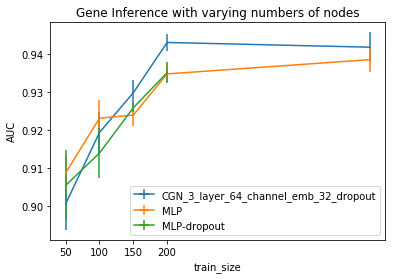

In [191]:
%matplotlib inline
for model in results["df"]["model"].unique():
    q = results["df"][results["df"].num_genes==200].groupby(['model','train_size'])['auc']
    index = q.mean()[model].index
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("train_size")
#plt.xscale("log")
plt.xticks(index)
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

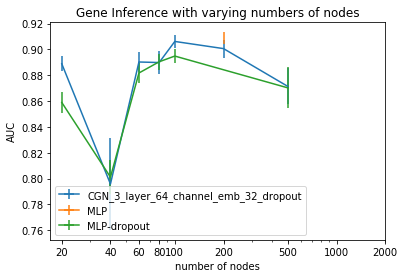

In [183]:
%matplotlib inline
for model in results["df"]["model"].unique():
    q = results["df"][results["df"].train_size==50].groupby(['model','num_genes'])['auc']
    index = q.mean()[model].index
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.xscale("log")
plt.xticks(sorted(results["df"]["num_genes"].unique()))
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

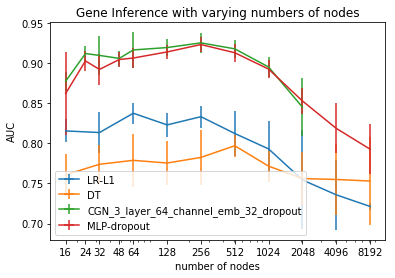

In [29]:
%matplotlib inline
for model in results["df"]["model"].unique():
    index = results["df"].groupby(['model','num_genes'])['auc'].mean()[model].index
    mean = results["df"].groupby(['model','num_genes'])['auc'].mean()[model]
    stderr = results["df"].groupby(['model','num_genes'])['auc'].std()[model]
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.xscale("log")
plt.xticks(sorted(results["df"]["num_genes"].unique()))
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

In [ ]:
#results_df = pd.DataFrame(columns=['model', 'num_genes', 'gene_name', 'auc', 'std'])
#results_df = results_df.append(data=pd.DataFrame(pd.DataFrame(data={'model':"LR", 'num_genes': 10.0, 'gene_name': "RPL5", 'auc':0.57, 'std': 0.01}, index=[0]))
len(["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"])
len([10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0])
len([0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92])
len([0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00])
results_df = pd.DataFrame(data={'model':["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"],
                   'num_genes': [10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0],
#                  'gene_name': ["RPL5", "RPL5"],
                   'auc': [0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92],
                   'std': [0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00]}, index=range(0, 28))
plt.figure()
titles = []
for model in [
    {'key': 'LR', 'method': lr},
    {'key': 'MLP', 'method': mlp},
    {'key': 'Decision Tree', 'method': decision_tree},
    {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': cgn_loop, 'num_channel': 64, 'num_layer': 3, 'add_emb': 32, 'use_gate': False, 'dropout': True, 'cuda': True},
    ]:
    temp_results = results_df.loc[results_df['model'] == model['key']].reset_index(drop=True)
    lines.append(plt.errorbar(temp_results.index, temp_results['auc'], xerr=0, yerr=temp_results['std'])[0])
    titles.append(model['key'])
    plt.xticks(list(temp_results.index), temp_results['num_genes'], rotation=70)
width = 0.2
plt.title("Inferring the value of RPL5 with varying numbers of genes")
plt.ylabel("AUC")
plt.xlabel("# genes")
plt.legend(lines, titles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)


In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_genes'], rotation=70)
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [ ]:
# Predict a gene from a growing number of Nodes
lr_results = pd.DataFrame([])
mlp_results = pd.DataFrame([])
cgn_results = pd.DataFrame([])
gene = "RPL5"
max_samples = 200
reload(data)
reload(models)
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')

for num_samples in range(10, max_samples, 20):
    lr_row = infer_gene(lr, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    lr_results = lr_results.append(lr_row).reset_index(drop=True)
    lr_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    cgn_row = infer_gene(cgn, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    cgn_results = cgn_results.append(cgn_row).reset_index(drop=True)
    cgn_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    print num_genes
    print cgn_results
    print lr_results

In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_samples'], rotation=70)
plt.title("Gene Inference with varying numbers of samples")
plt.ylabel("AUC")
plt.xlabel("number of samples")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)